In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip /content/drive/MyDrive/colab/images.zip
# !pip install wandb

In [2]:
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

import wandb

In [3]:
def set_seed(seed):
    # torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
# warnings.filterwarnings("ignore")
set_seed(3407)
wandb.login()

# model.zero_grad()
# loss.backward()
# optimizer.step()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: seara. Use `wandb login --relogin` to force relogin


True

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATAROOT = (
    "/home/seara/Desktop/Github/vk-try/images"
    if os.path.isdir("/home/seara/Desktop/Github/vk-try/images")
    else "/content/images"
)
WORKERS = 4
BATCH_SIZE = 128
NUM_EPOCHS = 1000
LR = 0.0002
BETA1 = 0.5
BETA2 = 0.999
IMAGE_SIZE = (64, 64)
LATENT_DIM = 100
FEATURES = 64

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim, features):
        super().__init__()
        self.net = nn.Sequential(
            *self.block(latent_dim, features * 16, 4, 1, 0),
            *self.block(features * 16, features * 8, 4, 2, 1),
            *self.block(features * 8, features * 4, 4, 2, 1),
            *self.block(features * 4, features * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                in_channels=features * 2,
                out_channels=3,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=True,
            ),
            nn.Tanh(),
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.net(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=features,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=True,
            ),
            nn.LeakyReLU(0.2, inplace=True),
            *self.block(features, features * 2, 4, 2, 1),
            *self.block(features * 2, features * 4, 4, 2, 1),
            *self.block(features * 4, features * 8, 4, 2, 1),
            nn.Conv2d(
                in_channels=features * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=True,
            ),
            nn.Sigmoid(),
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.net(x)

In [8]:
class DCGAN:
    def __init__(
        self,
        num_epochs,
        lr,
        beta1,
        beta2,
        latent_dim,
        features,
        device,
    ):

        self.num_epochs = num_epochs
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.latent_dim = latent_dim
        self.features = features
        self.device = device

        self.G = Generator(self.latent_dim, self.features)
        self.D = Discriminator(self.features)

        self.G.to(self.device)
        self.D.to(self.device)

        self.initialize_weights(self.G)
        self.initialize_weights(self.D)

        self.loss = nn.BCELoss()

        self.d_optimizer = optim.Adam(
            self.D.parameters(), lr=self.lr, betas=(self.beta1, self.beta2)
        )
        self.g_optimizer = optim.Adam(
            self.G.parameters(), lr=self.lr, betas=(self.beta1, self.beta2)
        )

    def train(self, dataloader):
        wandb.init(project="vk_try", name="DCGAN[leaky] with real label smoothing")

        self.G.train()
        self.D.train()

        self.noise_coef = 1

        for epoch in range(self.num_epochs):
            d_loss_list = []
            d_loss_real_list = []
            d_loss_fake_list = []
            g_loss_list = []
            for i, (real_images, _) in enumerate(dataloader):
                noise = torch.randn(
                    (real_images.size(0), self.latent_dim, 1, 1), device=self.device
                )
                gauss_noise = (
                    torch.randn(real_images.size(), device=self.device)
                    * self.noise_coef
                    + 0
                )
                real_images = real_images.to(self.device) + gauss_noise
                g_output = self.G(noise)

                # Discriminator step
                self.D.zero_grad()

                d_real_output = self.D(real_images).flatten()
                real_labels = torch.ones_like(d_real_output, device=self.device)
                real_labels = (
                    real_labels
                    - 0.3
                    + torch.rand(real_labels.shape, device=self.device) * 0.5
                )
                d_loss_real = self.loss(d_real_output, real_labels)

                d_fake_output = self.D(g_output.detach()).flatten()
                d_loss_fake = self.loss(
                    d_fake_output, torch.zeros_like(d_fake_output, device=self.device)
                )

                d_loss = (d_loss_real + d_loss_fake) / 2
                d_loss.backward()
                self.d_optimizer.step()

                # Generator step
                self.G.zero_grad()

                d_fake_output = self.D(g_output).flatten()
                d_real_output = self.D(real_images).flatten()
                g_loss = self.loss(
                    torch.cat((d_fake_output, d_real_output)),
                    torch.cat(
                        (
                            torch.ones_like(d_fake_output, device=self.device),
                            torch.zeros_like(d_real_output, device=self.device),
                        ),
                    ),
                )

                g_loss.backward()
                self.g_optimizer.step()

                # Logging
                d_loss_list.append(d_loss.item())
                d_loss_real_list.append(d_loss_real.item())
                d_loss_fake_list.append(d_loss_fake.item())
                g_loss_list.append(g_loss.item())

            if epoch % 30 == 0:
                self.noise_coef = self.noise_coef * 0.1

            if epoch % 100 == 0:
                images_count = 32
                gen_images = self.generate(images_count)
                plt.figure(figsize=(15, 15))
                plt.axis("off")
                plt.title("Fake Images")
                plt.imshow(
                    make_grid(
                        gen_images[:images_count].cpu(), padding=2, normalize=True
                    ).permute(1, 2, 0)
                )
                plt.show()
                self.G.train()
                self.D.train()
                path = (
                    f"/home/seara/Desktop/Github/vk-try/finalmodel{epoch}.pt"
                    if os.path.isdir("/home/seara/Desktop/Github/vk-try")
                    else f"/content/drive/MyDrive/colab/finalmodel{epoch}.pt"
                )
                self.save(path)

            # self.d_scheduler.step()
            # self.g_optimizer.step()

            metrics = {
                "d_loss": sum(d_loss_list) / len(d_loss_list),
                "d_loss_real": sum(d_loss_real_list) / len(d_loss_real_list),
                "d_loss_fake": sum(d_loss_fake_list) / len(d_loss_fake_list),
                "g_loss": sum(g_loss_list) / len(g_loss_list),
            }
            print(f"Epoch: {epoch}: {metrics}")
            wandb.log(metrics)

    def generate(self, images_count):
        self.D.eval()
        self.G.eval()
        with torch.no_grad():
            noise = torch.randn(images_count, 100, 1, 1, device=self.device)
            return self.G(noise).detach()

    def initialize_weights(self, model):
        for m in model.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def save(self, path):
        save_dict = {
            "discriminator": self.D.state_dict(),
            "generator": self.G.state_dict(),
            "d_optimizer": self.d_optimizer.state_dict(),
            "g_optimizer": self.g_optimizer.state_dict(),
        }
        torch.save(save_dict, path)

    def load(self, path):
        load_dict = torch.load(path)

        if "generator" in load_dict:
            print("Loaded gen")
            self.G.load_state_dict(load_dict["generator"])
        if "discriminator" in load_dict:
            print("Loaded dis")
            self.D.load_state_dict(load_dict["discriminator"])
        if "d_optimizer" in load_dict:
            print("Loaded d_opt")
            self.d_optimizer.load_state_dict(load_dict["d_optimizer"])
        if "g_optimizer" in load_dict:
            print("Loaded g_opt")
            self.g_optimizer.load_state_dict(load_dict["g_optimizer"])

In [9]:
dataset = ImageFolder(
    root=DATAROOT,
    transform=transforms.Compose(
        [
            transforms.Resize(IMAGE_SIZE),
            transforms.ColorJitter(saturation=0.5, hue=0.5),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)
dataloader = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS
)

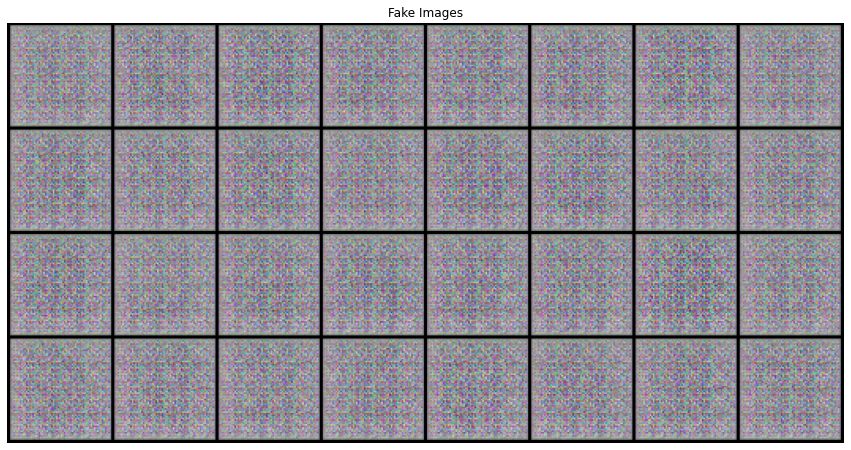

Epoch: 0: {'d_loss': 2.2142088770866395, 'd_loss_real': 2.196350857615471, 'd_loss_fake': 2.232066908478737, 'g_loss': 4.384323126077652}
Epoch: 1: {'d_loss': 1.3979012846946717, 'd_loss_real': 1.3498571529984473, 'd_loss_fake': 1.445945422886871, 'g_loss': 6.360299015045166}
Epoch: 2: {'d_loss': 1.2316345244646072, 'd_loss_real': 1.3956047207117082, 'd_loss_fake': 1.0676643270999193, 'g_loss': 3.636936271190643}
Epoch: 3: {'d_loss': 0.8580462753772735, 'd_loss_real': 1.0351661771535874, 'd_loss_fake': 0.6809263810515404, 'g_loss': 1.9261216282844544}
Epoch: 4: {'d_loss': 0.5657127067446709, 'd_loss_real': 0.6875773146748543, 'd_loss_fake': 0.4438480943441391, 'g_loss': 1.8514081239700317}
Epoch: 5: {'d_loss': 0.5449462682008743, 'd_loss_real': 0.6390422269701957, 'd_loss_fake': 0.4508503094315529, 'g_loss': 1.5696126341819763}
Epoch: 6: {'d_loss': 0.5596062824130058, 'd_loss_real': 0.6341370537877082, 'd_loss_fake': 0.48507550209760664, 'g_loss': 1.535248303413391}
Epoch: 7: {'d_loss'

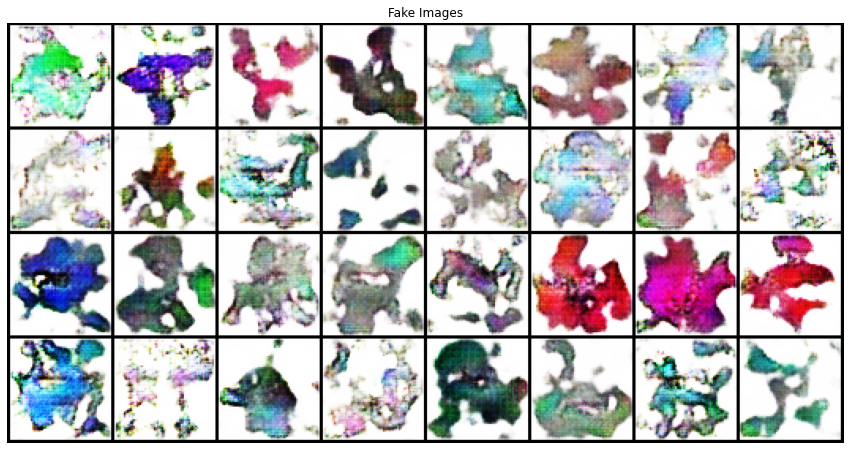

Epoch: 100: {'d_loss': 0.48907575458288194, 'd_loss_real': 0.5546908408403397, 'd_loss_fake': 0.42346065789461135, 'g_loss': 1.6579381227493286}
Epoch: 101: {'d_loss': 0.45337963104248047, 'd_loss_real': 0.5281412035226822, 'd_loss_fake': 0.37861805856227876, 'g_loss': 1.6384991228580474}
Epoch: 102: {'d_loss': 0.45930521935224533, 'd_loss_real': 0.5347703590989112, 'd_loss_fake': 0.383840075135231, 'g_loss': 1.6692782282829284}
Epoch: 103: {'d_loss': 0.5815481096506119, 'd_loss_real': 0.6512851998209953, 'd_loss_fake': 0.5118110038340091, 'g_loss': 1.8343530535697936}
Epoch: 104: {'d_loss': 0.4536231279373169, 'd_loss_real': 0.5254096373915672, 'd_loss_fake': 0.38183661699295046, 'g_loss': 1.6608637690544128}
Epoch: 105: {'d_loss': 0.4671422153711319, 'd_loss_real': 0.5361210651695728, 'd_loss_fake': 0.39816338159143927, 'g_loss': 1.6928275763988494}
Epoch: 106: {'d_loss': 0.4241643130779266, 'd_loss_real': 0.5040348306298256, 'd_loss_fake': 0.3442937979474664, 'g_loss': 1.72308117151

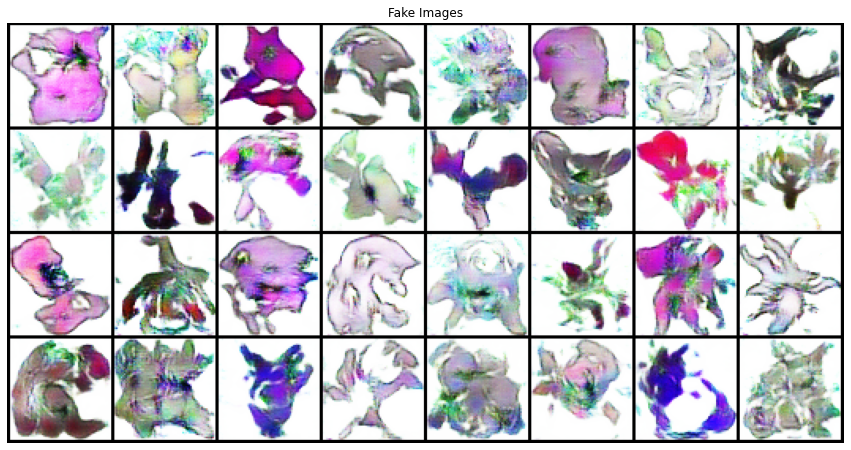

Epoch: 200: {'d_loss': 0.3037190198898315, 'd_loss_real': 0.38615052178502085, 'd_loss_fake': 0.22128752004355193, 'g_loss': 2.348723316192627}
Epoch: 201: {'d_loss': 0.3025407217442989, 'd_loss_real': 0.3682695932686329, 'd_loss_fake': 0.23681184630841018, 'g_loss': 2.3420703768730164}
Epoch: 202: {'d_loss': 0.297398154437542, 'd_loss_real': 0.3828096777200699, 'd_loss_fake': 0.2119866253808141, 'g_loss': 2.362273836135864}
Epoch: 203: {'d_loss': 0.34551566317677496, 'd_loss_real': 0.4081978604197502, 'd_loss_fake': 0.2828334607183933, 'g_loss': 2.3898701906204223}
Epoch: 204: {'d_loss': 0.3643217273056507, 'd_loss_real': 0.4560666248202324, 'd_loss_fake': 0.2725768333300948, 'g_loss': 2.471427881717682}
Epoch: 205: {'d_loss': 0.274506014585495, 'd_loss_real': 0.3417082950472832, 'd_loss_fake': 0.2073037350550294, 'g_loss': 2.3191707253456117}
Epoch: 206: {'d_loss': 0.29313520789146424, 'd_loss_real': 0.36962129920721054, 'd_loss_fake': 0.21664912588894367, 'g_loss': 2.39763263463974}

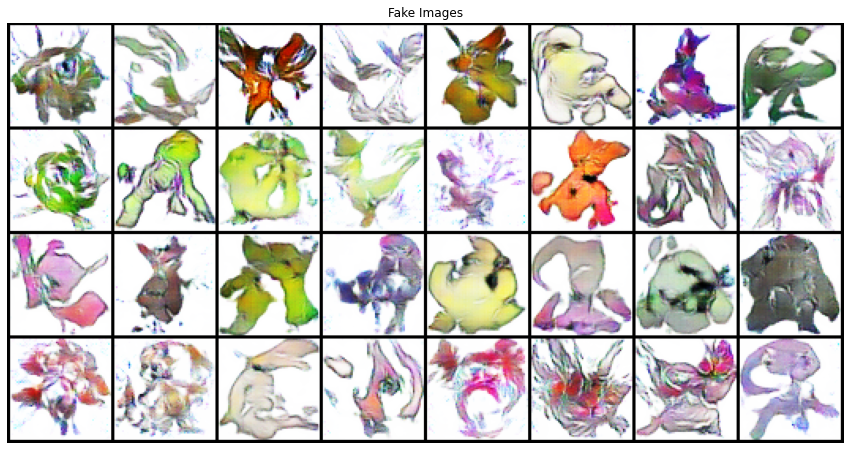

Epoch: 300: {'d_loss': 0.18300689980387688, 'd_loss_real': 0.2893518000841141, 'd_loss_fake': 0.07666199859231711, 'g_loss': 3.233289098739624}
Epoch: 301: {'d_loss': 0.16376953423023224, 'd_loss_real': 0.2603681392967701, 'd_loss_fake': 0.06717093270272016, 'g_loss': 3.2112550497055055}
Epoch: 302: {'d_loss': 0.1665694434195757, 'd_loss_real': 0.2449291728436947, 'd_loss_fake': 0.08820971278473735, 'g_loss': 3.2850221157073975}
Epoch: 303: {'d_loss': 0.16249583922326566, 'd_loss_real': 0.2543127484619617, 'd_loss_fake': 0.07067893026396632, 'g_loss': 3.295995461940765}
Epoch: 304: {'d_loss': 0.19312335923314095, 'd_loss_real': 0.2949411116540432, 'd_loss_fake': 0.09130560727789998, 'g_loss': 3.285748243331909}
Epoch: 305: {'d_loss': 0.16729931086301802, 'd_loss_real': 0.26550333872437476, 'd_loss_fake': 0.06909528020769358, 'g_loss': 3.2298744201660154}
Epoch: 306: {'d_loss': 0.1566199354827404, 'd_loss_real': 0.25121918469667437, 'd_loss_fake': 0.06202068473212421, 'g_loss': 3.354509

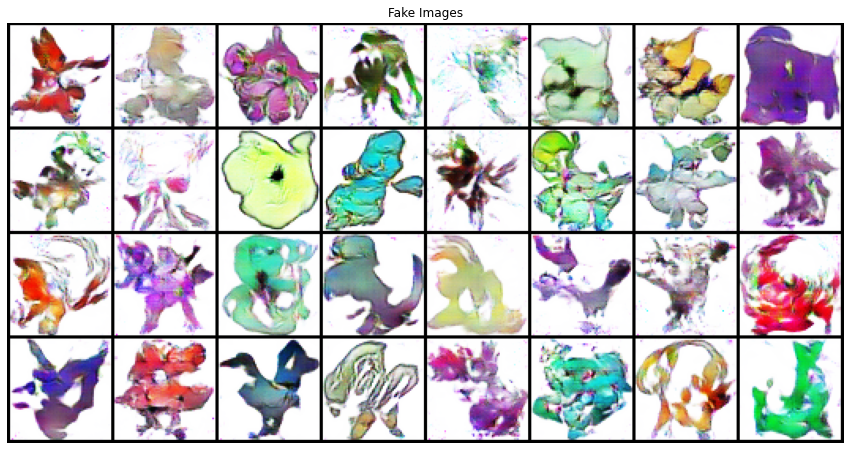

Epoch: 400: {'d_loss': 0.1648685045540333, 'd_loss_real': 0.2572188675403595, 'd_loss_fake': 0.0725181425921619, 'g_loss': 3.1943699717521667}
Epoch: 401: {'d_loss': 0.1520002294331789, 'd_loss_real': 0.23739229179918767, 'd_loss_fake': 0.06660816902294756, 'g_loss': 3.332680547237396}
Epoch: 402: {'d_loss': 0.15092292316257955, 'd_loss_real': 0.24507123976945877, 'd_loss_fake': 0.05677460376173258, 'g_loss': 3.408043146133423}
Epoch: 403: {'d_loss': 0.14005392119288446, 'd_loss_real': 0.2317057941108942, 'd_loss_fake': 0.048402046971023086, 'g_loss': 3.4394715905189512}
Epoch: 404: {'d_loss': 0.14153284914791583, 'd_loss_real': 0.23686585426330567, 'd_loss_fake': 0.046199849154800174, 'g_loss': 3.4805699706077577}
Epoch: 405: {'d_loss': 0.14927769228816032, 'd_loss_real': 0.24776235446333886, 'd_loss_fake': 0.05079303183592856, 'g_loss': 3.5532694816589356}
Epoch: 406: {'d_loss': 0.14112025424838065, 'd_loss_real': 0.2376503601670265, 'd_loss_fake': 0.044590151961892845, 'g_loss': 3.5

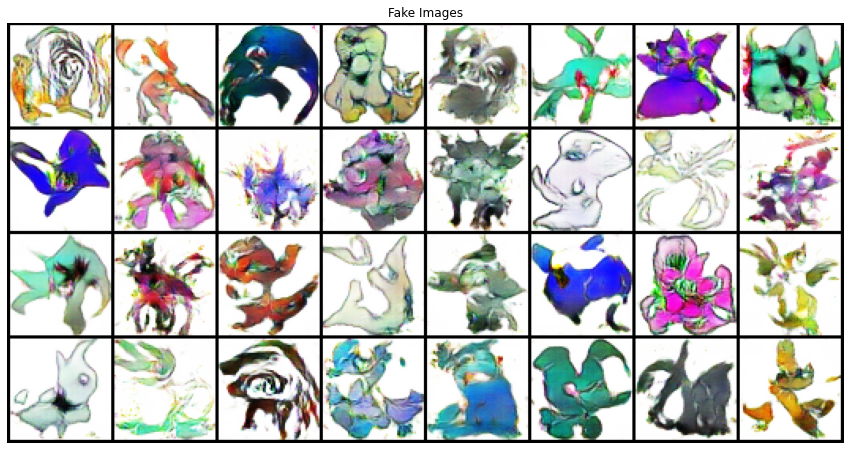

Epoch: 500: {'d_loss': 0.1574576437473297, 'd_loss_real': 0.2758583277463913, 'd_loss_fake': 0.03905696142464876, 'g_loss': 3.8890145659446715}
Epoch: 501: {'d_loss': 0.13049273155629634, 'd_loss_real': 0.23286282941699027, 'd_loss_fake': 0.028122633555904032, 'g_loss': 3.9414926528930665}
Epoch: 502: {'d_loss': 0.13987985700368882, 'd_loss_real': 0.24345430210232735, 'd_loss_fake': 0.036305411625653504, 'g_loss': 3.983482575416565}
Epoch: 503: {'d_loss': 0.15107690766453744, 'd_loss_real': 0.2690273955464363, 'd_loss_fake': 0.03312641982920468, 'g_loss': 3.9702094435691833}
Epoch: 504: {'d_loss': 0.18179019689559936, 'd_loss_real': 0.2953896775841713, 'd_loss_fake': 0.06819071373902261, 'g_loss': 3.9624614834785463}
Epoch: 505: {'d_loss': 0.1384297266602516, 'd_loss_real': 0.24211861826479436, 'd_loss_fake': 0.03474083330947906, 'g_loss': 3.991794395446777}
Epoch: 506: {'d_loss': 0.13683323785662652, 'd_loss_real': 0.24341405406594277, 'd_loss_fake': 0.030252422764897348, 'g_loss': 3.

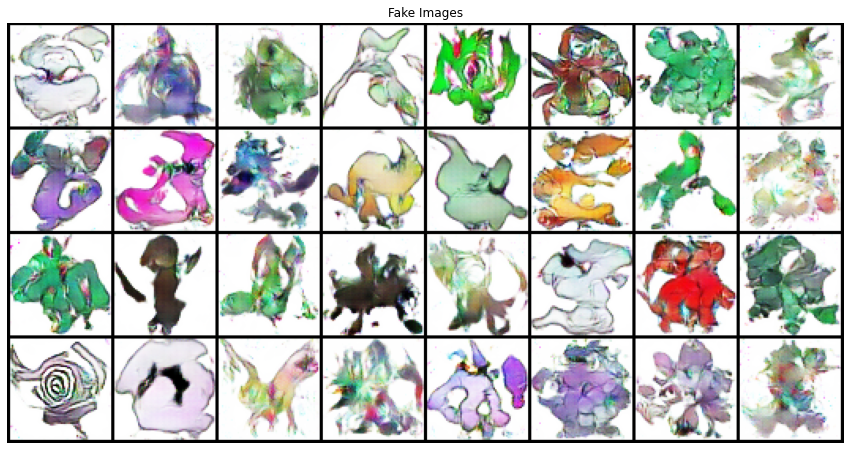

Epoch: 600: {'d_loss': 0.13777021802961825, 'd_loss_real': 0.2528600864112377, 'd_loss_fake': 0.022680349787697195, 'g_loss': 4.1248885750770565}
Epoch: 601: {'d_loss': 0.13517970144748687, 'd_loss_real': 0.24290867298841476, 'd_loss_fake': 0.02745072729885578, 'g_loss': 4.107688415050506}
Epoch: 602: {'d_loss': 0.14340706020593644, 'd_loss_real': 0.25195751190185545, 'd_loss_fake': 0.0348566068103537, 'g_loss': 4.118850779533386}
Epoch: 603: {'d_loss': 0.13450412601232528, 'd_loss_real': 0.23964582085609437, 'd_loss_fake': 0.029362430120818316, 'g_loss': 4.066868472099304}
Epoch: 604: {'d_loss': 0.1342929784208536, 'd_loss_real': 0.2447964683175087, 'd_loss_fake': 0.023789487942121924, 'g_loss': 4.092315566539765}
Epoch: 605: {'d_loss': 0.34819668531417847, 'd_loss_real': 0.49424159452319144, 'd_loss_fake': 0.20215176586061717, 'g_loss': 4.054326927661895}
Epoch: 606: {'d_loss': 0.16673313155770303, 'd_loss_real': 0.2482799582183361, 'd_loss_fake': 0.08518630228936672, 'g_loss': 3.798

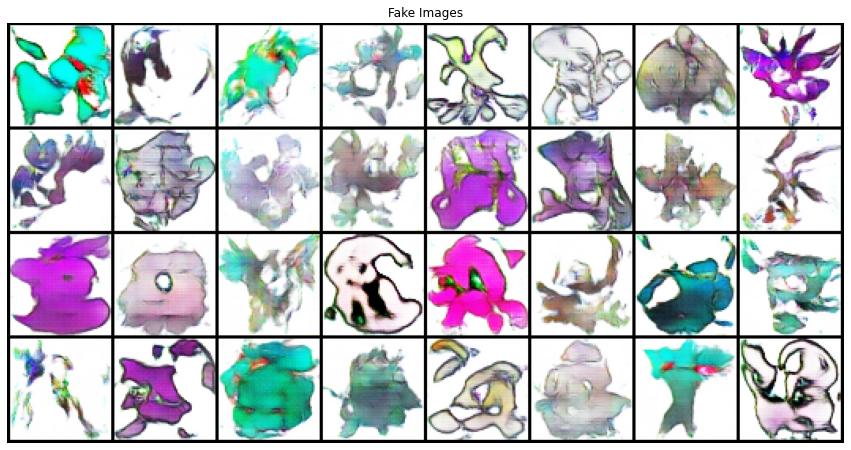

Epoch: 700: {'d_loss': 0.8540263921022415, 'd_loss_real': 0.9229490354657173, 'd_loss_fake': 0.7851037610322237, 'g_loss': 1.9754249095916747}
Epoch: 701: {'d_loss': 0.4174878127872944, 'd_loss_real': 0.5059417933225632, 'd_loss_fake': 0.3290338307619095, 'g_loss': 2.7876928806304933}
Epoch: 702: {'d_loss': 0.2627870924770832, 'd_loss_real': 0.3704232171177864, 'd_loss_fake': 0.15515096476301551, 'g_loss': 3.337924063205719}
Epoch: 703: {'d_loss': 0.1921958550810814, 'd_loss_real': 0.29748150557279585, 'd_loss_fake': 0.08691020272672176, 'g_loss': 3.4667887091636658}
Epoch: 704: {'d_loss': 0.154826807230711, 'd_loss_real': 0.2599062189459801, 'd_loss_fake': 0.04974739644676447, 'g_loss': 3.6458115458488463}
Epoch: 705: {'d_loss': 0.1472376212477684, 'd_loss_real': 0.2438634429126978, 'd_loss_fake': 0.05061179799959063, 'g_loss': 3.7818013072013854}
Epoch: 706: {'d_loss': 0.144599150121212, 'd_loss_real': 0.25344648733735087, 'd_loss_fake': 0.03575181029736996, 'g_loss': 3.8170818328857

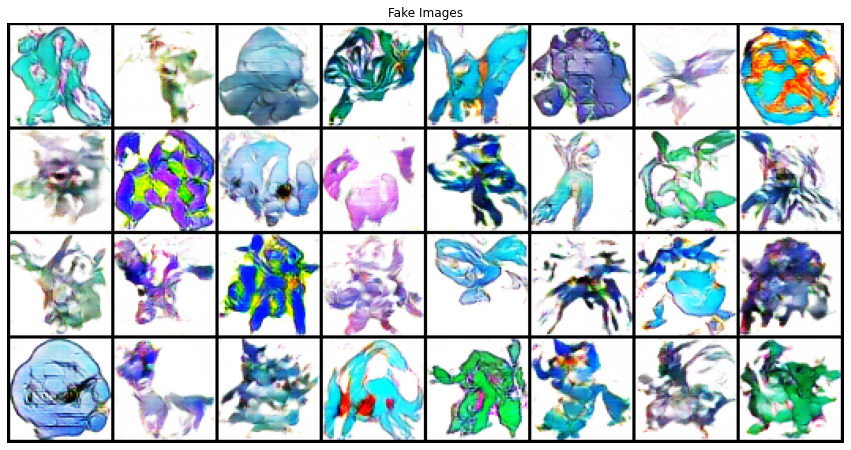

Epoch: 800: {'d_loss': 0.2289087288081646, 'd_loss_real': 0.3482141435146332, 'd_loss_fake': 0.10960331566166133, 'g_loss': 4.069972515106201}
Epoch: 801: {'d_loss': 0.14125142246484756, 'd_loss_real': 0.249282119423151, 'd_loss_fake': 0.033220725832507014, 'g_loss': 4.108734464645385}
Epoch: 802: {'d_loss': 0.14158594347536563, 'd_loss_real': 0.2625942051410675, 'd_loss_fake': 0.020577680366113783, 'g_loss': 4.050765585899353}
Epoch: 803: {'d_loss': 0.13289726227521897, 'd_loss_real': 0.24408080242574215, 'd_loss_fake': 0.021713721472769974, 'g_loss': 4.136799895763398}
Epoch: 804: {'d_loss': 0.12746531367301941, 'd_loss_real': 0.23723129108548163, 'd_loss_fake': 0.017699336423538624, 'g_loss': 4.2077168941497805}
Epoch: 805: {'d_loss': 0.13807630725204945, 'd_loss_real': 0.2577046237885952, 'd_loss_fake': 0.01844798808451742, 'g_loss': 4.258031177520752}
Epoch: 806: {'d_loss': 0.13881078138947486, 'd_loss_real': 0.25529495999217033, 'd_loss_fake': 0.02232660260051489, 'g_loss': 4.253

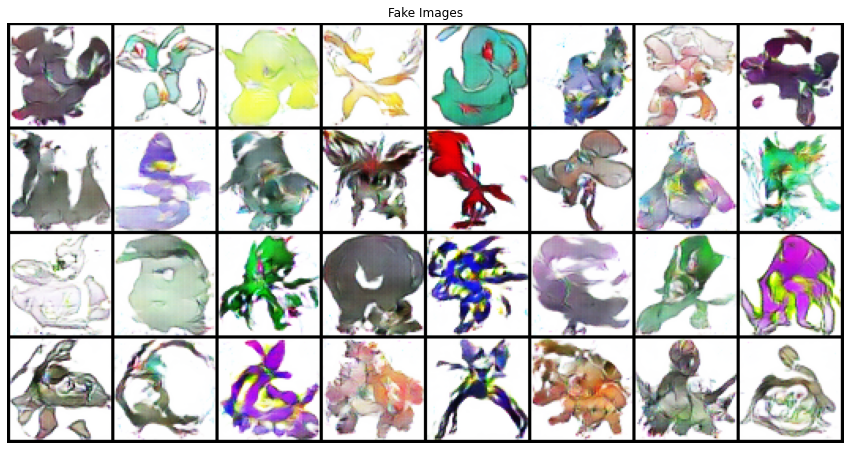

Epoch: 900: {'d_loss': 0.1440966498106718, 'd_loss_real': 0.2691589564085007, 'd_loss_fake': 0.01903434458654374, 'g_loss': 4.384929466247558}
Epoch: 901: {'d_loss': 0.15176417864859104, 'd_loss_real': 0.2857859030365944, 'd_loss_fake': 0.017742453480605037, 'g_loss': 4.359165549278259}
Epoch: 902: {'d_loss': 0.13369549252092838, 'd_loss_real': 0.25064833238720896, 'd_loss_fake': 0.016742652957327665, 'g_loss': 4.428534030914307}
Epoch: 903: {'d_loss': 0.13858341351151465, 'd_loss_real': 0.2622434265911579, 'd_loss_fake': 0.014923404133878649, 'g_loss': 4.323635244369507}
Epoch: 904: {'d_loss': 0.13110913150012493, 'd_loss_real': 0.24327446818351744, 'd_loss_fake': 0.01894379339646548, 'g_loss': 4.423892498016357}
Epoch: 905: {'d_loss': 0.12985757775604725, 'd_loss_real': 0.24584872350096704, 'd_loss_fake': 0.0138664297061041, 'g_loss': 4.411795377731323}
Epoch: 906: {'d_loss': 0.17721721343696117, 'd_loss_real': 0.30437849313020704, 'd_loss_fake': 0.05005593529203907, 'g_loss': 4.3645

In [10]:
model = DCGAN(NUM_EPOCHS, LR, BETA1, BETA2, LATENT_DIM, FEATURES, DEVICE)
model.train(dataloader)

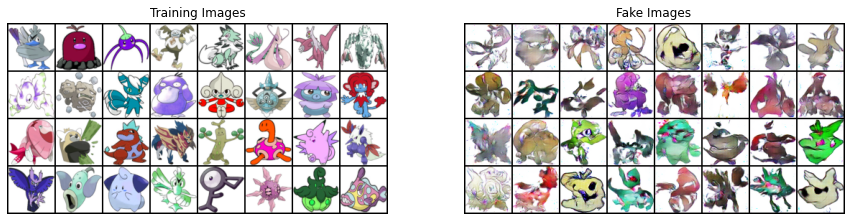

In [11]:
images_count = 32
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    make_grid(
        next(iter(dataloader))[0][:images_count], padding=2, normalize=True
    ).permute(1, 2, 0)
)

gen_images = model.generate(images_count)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(make_grid(gen_images.cpu(), padding=2, normalize=True).permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


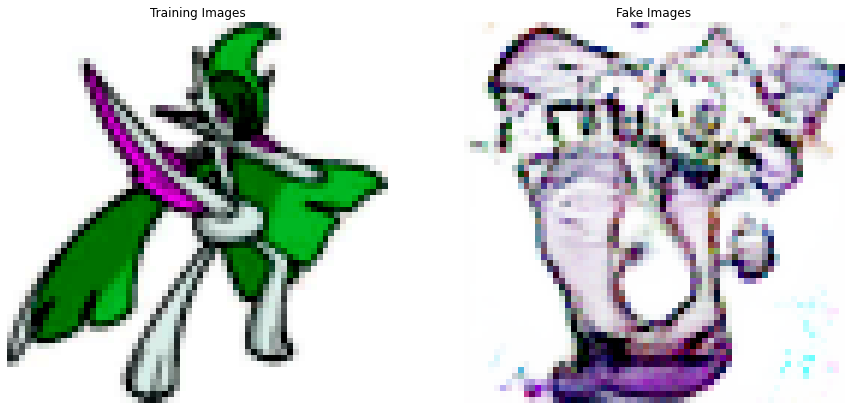

In [20]:
images_count = 1
image = next(iter(dataloader))[0]
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Training Images")
plt.imshow(image[0].permute(1, 2, 0))

gen_images = model.generate(images_count)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(gen_images[0].cpu().permute(1, 2, 0))
plt.show()